In [1]:
import keras
from keras.applications import DenseNet121 #DenseNet121, DenseNet169, DenseNet201, ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from label2onehot import label2onehot
from onehot2label import onehot2label
from label_dict import label_dict
import gc

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Use GPU
config = tf.ConfigProto( device_count = {'GPU': 2 , 'CPU': 4}, log_device_placement=True ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [3]:
#Import train set
x = np.load('train_crop.npy')/255.
y_label = np.load('train.npy')

In [4]:
#Convert label to onehot
#onehot_y = label2onehot(y[:, 0], 256)
#np.save('onehot_y_train.npy',onehot_y)
#from keras.utils.np_utils import to_categorical
#y = to_categorical(y_label[:,0], num_classes=256)
y = y_label[:,0]

In [5]:
#Build the new model based on DenseNet121
def getmodel(num_classes=256):
    '''
    Build the new model based on DenseNet121, DenseNet169, DenseNet201
    
    Argument:
    num_classes -- (int) number of classes
    
    Return:
    model -- the new compiled model
    '''
    
    orig_model = DenseNet121(include_top=False, weights='imagenet', pooling='avg', classes=num_classes)
    densenet_out = orig_model.layers[-1].output
    out = Dense(256, activation='softmax', kernel_initializer='glorot_uniform')(densenet_out)
    model = Model(input=orig_model.input, output=out)
    model.compile(loss= "sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [6]:
densemodel = getmodel(256)

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  app.launch_new_instance()


In [7]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="DenseNet121_transfer_crop.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]
history = densemodel.fit(x, y, epochs=15, batch_size=32, validation_split=0.25, callbacks=callbacks_list)

Train on 17868 samples, validate on 5956 samples
Epoch 1/15
17868/17868 [==============================] - 230s 13ms/step - loss: 3.0183 - acc: 0.3570 - val_loss: 3.3918 - val_acc: 0.3422

Epoch 00001: val_acc improved from -inf to 0.34218, saving model to DenseNet121_transfer_crop.hdf5
Epoch 2/15
17868/17868 [==============================] - 211s 12ms/step - loss: 1.6559 - acc: 0.5999 - val_loss: 2.3177 - val_acc: 0.4830

Epoch 00002: val_acc improved from 0.34218 to 0.48304, saving model to DenseNet121_transfer_crop.hdf5
Epoch 3/15
17868/17868 [==============================] - 210s 12ms/step - loss: 1.2185 - acc: 0.6860 - val_loss: 3.3955 - val_acc: 0.3479

Epoch 00003: val_acc did not improve
Epoch 4/15
17868/17868 [==============================] - 209s 12ms/step - loss: 0.8877 - acc: 0.7639 - val_loss: 2.2642 - val_acc: 0.5247

Epoch 00004: val_acc improved from 0.48304 to 0.52468, saving model to DenseNet121_transfer_crop.hdf5
Epoch 5/15
17868/17868 [===========================

In [8]:
#release RAM
del x, y
gc.collect()

13223

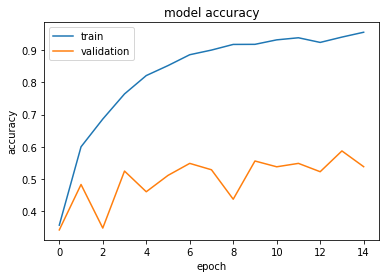

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

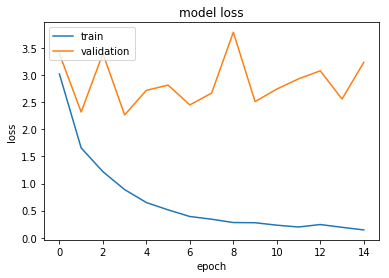

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
#Import test dataset
X_test = np.load('test_crop.npy')/255.
Y_test = np.load('onehot_y_test.npy')
y_test = np.load('test.npy')

In [12]:
##Convert label to onehot
#y_test = label2onehot(Y_test[:, 0], 256)
#np.save('onehot_y_test.npy', y_test)

In [13]:
densemodel.load_weights('DenseNet121_transfer_crop.hdf5')

In [14]:
#evaluate
eva = densemodel.evaluate(X_test, y_test[:,0], batch_size=32, verbose=1, sample_weight=None)
print()
print("Loss = " + str(eva[0]))
print("Test Accuracy = " + str(eva[1]))

5956/5956 [==============================] - 26s 4ms/step
()
Loss = 2.5804794713744705
Test Accuracy = 0.5780725319006045


This image is: diamond-ring
The dict_label of image is: 54


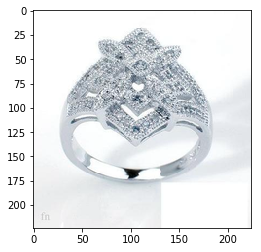

In [15]:
#predict a new image
predict_num = 1111
dict_label = label_dict()
X_predict = X_test[predict_num]
print('This image is: ' + dict_label[y_test[:, 0][predict_num]+1])
print('The dict_label of image is: '+str(y_test[:, 0][predict_num]+1))
plt.imshow(X_predict)

In [16]:
#predict
predict_vector = densemodel.predict(np.expand_dims(X_predict, axis=0))
index = np.where(predict_vector[0] == np.max(predict_vector[0]))
print('The predict dict_label of image is: '+str(index[0][0]+1))
print('The predict probability of image is: '+str(predict_vector[0, index[0][0]]))
print('This image is: ' + dict_label[index[0][0] + 1])

The predict dict_label of image is: 54
The predict probability of image is: 0.8205689
This image is: diamond-ring
